In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import math
from imblearn.over_sampling import RandomOverSampler
import cv2

In [2]:
path = "../germany_dataset/train.csv"
df = pd.read_csv(path)
df = df.dropna()
filename="mobileNetV3"

In [3]:
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,length,height
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,17,15
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,18,16
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,18,16
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,18,16
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,18,16


In [4]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,length,height
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390,39.197786,38.765998
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238,21.821369,20.828697
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000,15.000000,15.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000,24.000000,24.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000,33.000000,32.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000,47.000000,47.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000,203.000000,185.000000


In [5]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 32
resize_y  = 32
num_of_channels = 3
directory = "../germany_dataset/"
testdir = "../germany_dataset/test.csv"
Epochs=100
train_length = len(df)
Y_col_name="ClassId"

In [6]:
# Necessary Functions
def remove_outlier(df,parameter):
    Percentile25 = df[parameter].quantile(0.25)
    Percentile75 = df[parameter].quantile(0.75)
    iqr = Percentile75 - Percentile25
    lowerlimit = Percentile25 - 1.5*iqr
    upperlimit = Percentile75 + 1.5*iqr
    temp1 = df[parameter]>lowerlimit
    temp2 = df[parameter]<upperlimit
    return df[temp1 & temp2] 

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
    

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  39209


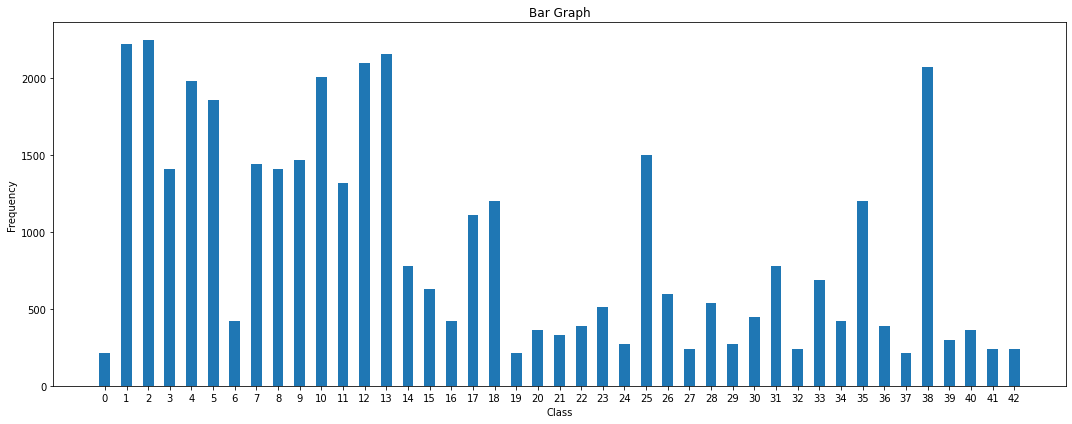

In [7]:
#Statistics of Data
viewStatistics(df)

In [8]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  39209


Total Training Examples :  96750


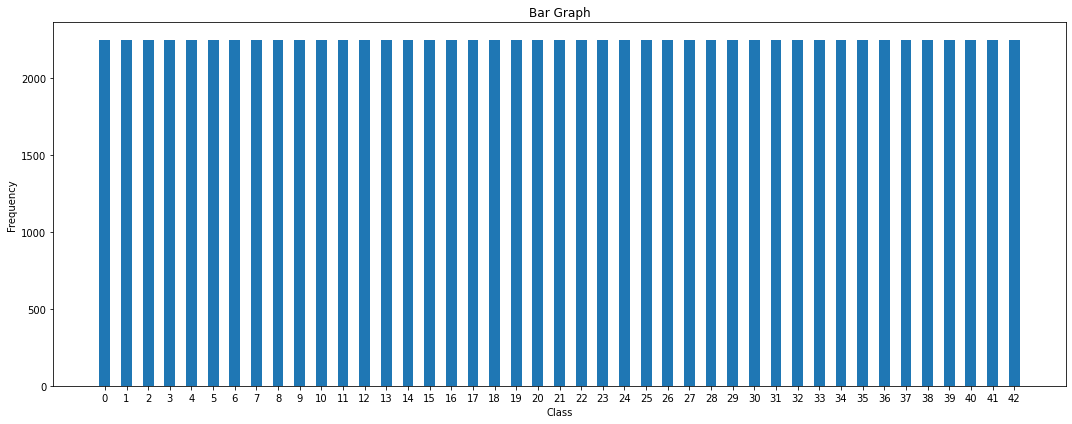

In [9]:
X = df.drop(Y_col_name, axis=1)
y = df[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df = pd.DataFrame(X_resampled, columns=X.columns)
df[Y_col_name] = y_resampled
df[Y_col_name].astype(str)

viewStatistics(df)

In [10]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Path,length,height,ClassId
0,27,26,5,5,22,20,Train/20/00020_00000_00000.png,17,15,20
1,28,27,5,6,23,22,Train/20/00020_00000_00001.png,18,16,20
2,29,26,6,5,24,21,Train/20/00020_00000_00002.png,18,16,20
3,28,27,5,6,23,22,Train/20/00020_00000_00003.png,18,16,20
4,28,26,5,5,23,21,Train/20/00020_00000_00004.png,18,16,20


In [11]:
# Sample Images and there crop according to data given in csv
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[6])
        ax.imshow(img)
        img = img.crop((val[2],val[3],val[4],val[5]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title(directory+val[6])
        print(directory+val[6])
    ax.axis('off')

def showTestExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[7])
        ax.imshow(img)
        img = img.crop((val[2],val[3],val[4],val[5]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title("Class : "+str(val[6]))
    ax.axis('off')
    

../germany_dataset/Train/24/00024_00008_00020.png
../germany_dataset/Train/39/00039_00007_00019.png
../germany_dataset/Train/41/00041_00006_00019.png
../germany_dataset/Train/26/00026_00001_00025.png
../germany_dataset/Train/21/00021_00007_00009.png


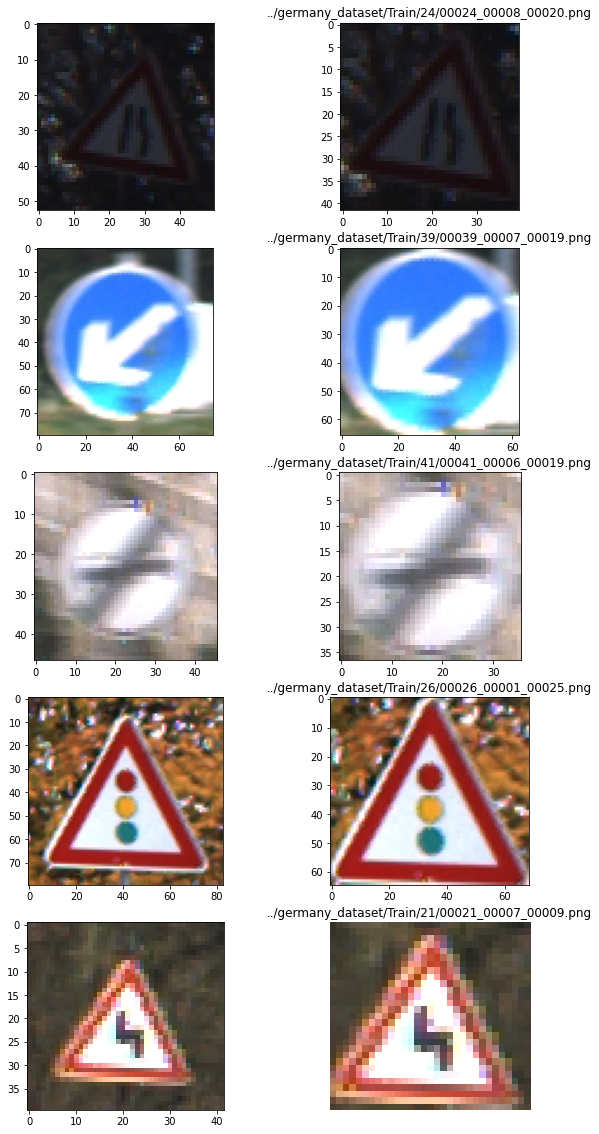

In [12]:
showExamples(df)

In [13]:
model = MobileNetV3Large(weights=None, input_shape=(resize_x, resize_y, 3), classes=num_of_classes)

# Display the model summary
model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 16, 16, 16)   432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 16, 16, 16)   64          Conv[0][0]                       
___________________________________________________________________________________

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
print(df["ClassId"].dtype)
df["ClassId"] = df["ClassId"].astype(str)
print(df["ClassId"].dtype)

int64
object


In [16]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Path,length,height,ClassId
0,27,26,5,5,22,20,Train/20/00020_00000_00000.png,17,15,20
1,28,27,5,6,23,22,Train/20/00020_00000_00001.png,18,16,20
2,29,26,6,5,24,21,Train/20/00020_00000_00002.png,18,16,20
3,28,27,5,6,23,22,Train/20/00020_00000_00003.png,18,16,20
4,28,26,5,5,23,21,Train/20/00020_00000_00004.png,18,16,20


In [17]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = directory
        self.resize_x = size_x
        self.resize_y = size_y
    
    def resize_and_center(self,image, target_height, target_width):
        original_height, original_width= image.size
        height_ratio = target_height / original_height
        width_ratio = target_width / original_width
        resize_ratio = min(height_ratio, width_ratio)
        new_height = int(original_height * resize_ratio)
        new_width = int(original_width * resize_ratio)
        image  = np.array(image)
        resized_image = cv2.resize(image, (new_width, new_height))
        pad_height = max(0, (target_height - new_height) // 2)
        pad_width = max(0, (target_width - new_width) // 2)
        centered_image = cv2.copyMakeBorder(resized_image, pad_height, target_height - new_height - pad_height,pad_width, target_width - new_width - pad_width,cv2.BORDER_CONSTANT, value=(255, 255, 255))
        return centered_image

    def Do_Crop(self,path,x1,y1,x2,y2):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        img = self.resize_and_center(img,self.resize_x,self.resize_y)
        img = np.array(img,dtype=float)
        return img
    
    def Row_Data(self,row):
        self.X.append(self.Do_Crop(row["Path"],row["Roi.X1"],row["Roi.Y1"],row["Roi.X2"],row["Roi.Y2"]))
        self.Y.append(int(row["ClassId"]))
        
    def Get_Data(self):
        self.X = []
        self.Y = []
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)

In [18]:
def miniDataTrain(model,df,train_split):
    data = Data(df,resize_x,resize_y)
    data.Get_Data()
    X_train = data.X
    Y_train = data.Y
    X_train = X_train/255.0
    history = model.fit(X_train,Y_train,epochs=1,batch_size=len(X_train),validation_split=1-train_split,verbose=0)
    training_accuracy = history.history['accuracy'][0]
    validation_accuracy = history.history['val_accuracy'][0]
    loss = history.history['loss'][0]
    val_loss = history.history['val_loss'][0]
    return [training_accuracy,validation_accuracy,loss,val_loss]    

def SingleEpochTrain(model,df,batchsize=2000,train_split=0.9):
    num_train = len(df)
    num_mini_trains = math.ceil(num_train/batchsize)
    training_accuracy = 0
    validation_accuracy = 0
    loss = 0
    val_loss = 0
    starting_time = time.time()
    for i in range(num_mini_trains):      
        if(num_mini_trains == i+1):
            presentBatchSize = num_train - i*batchsize
        else :
            presentBatchSize = batchsize      
        df1 = df.iloc[i*batchsize:i*batchsize+presentBatchSize,:]
        params = miniDataTrain(model,df1,train_split)
        training_accuracy += presentBatchSize*train_split*params[0]
        validation_accuracy+= presentBatchSize*(1-train_split)*params[1]
        loss += params[2]
        val_loss += params[3]
    training_accuracy/=(num_train*train_split)
    validation_accuracy/=(num_train*(1-train_split))
    
    ending_time = time.time()
    total_time = ending_time - starting_time
    total_time/=60
    print("Accuracy: ",training_accuracy," Val Accuracy: ",validation_accuracy," Trained for ",total_time," min")
    return [training_accuracy,validation_accuracy,loss,val_loss];

In [19]:
start_time   = time.time()

training_accuracy = []
validation_accuracy = []
loss = []
val_loss = []

for i in range(Epochs):
    print("Epoch : ", i)
    params = SingleEpochTrain(model,df)
    training_accuracy.append(params[0])
    validation_accuracy.append(params[1])
    loss.append(params[2])
    val_loss.append(params[3])

end_time = time.time()
print("Time taken : ", (end_time - start_time)/60," min")

Epoch :  0
Accuracy:  0.009830605628532033  Val Accuracy:  0.020671834625322995  Trained for  2.243139123916626  min
Epoch :  1
Accuracy:  0.012529428716200266  Val Accuracy:  0.0  Trained for  1.8976971745491027  min
Epoch :  2
Accuracy:  0.0044444443547294425  Val Accuracy:  0.0  Trained for  1.9305694540341696  min
Epoch :  3
Accuracy:  0.0078323285500892  Val Accuracy:  0.020671834625322995  Trained for  1.8887550075848898  min
Epoch :  4
Accuracy:  0.013138099022459921  Val Accuracy:  0.0  Trained for  1.913134225209554  min
Epoch :  5
Accuracy:  0.01826012021896865  Val Accuracy:  0.0  Trained for  1.886358884970347  min
Epoch :  6
Accuracy:  0.018501291807153736  Val Accuracy:  0.0  Trained for  1.84981613556544  min
Epoch :  7
Accuracy:  0.008188343296448389  Val Accuracy:  0.0  Trained for  1.8781628092130025  min
Epoch :  8
Accuracy:  0.009175997761677402  Val Accuracy:  0.0  Trained for  1.878779379526774  min
Epoch :  9
Accuracy:  0.010508182355099253  Val Accuracy:  0.0  T

In [20]:
#Saving the model
# model.save(filename)

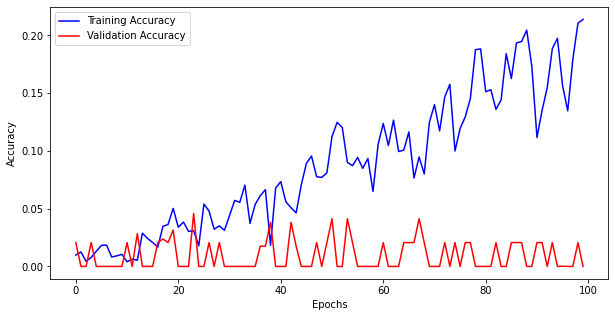

In [21]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

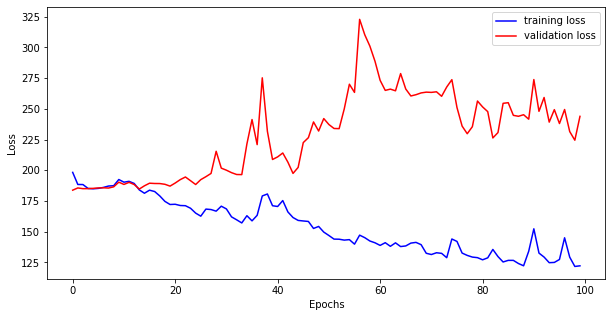

In [22]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [23]:
#Loading weights into CNN model 
# model = tf.keras.models.load_model("CNN_SimpleLayered")

In [24]:
df_test = pd.read_csv(testdir)
df_test["ClassId"] =df_test["ClassId"].astype(str)
print("Number of Test Images are ", len(df_test))
df_test.dropna()
df_test.head()

Number of Test Images are  12630


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


Total Training Examples :  12630


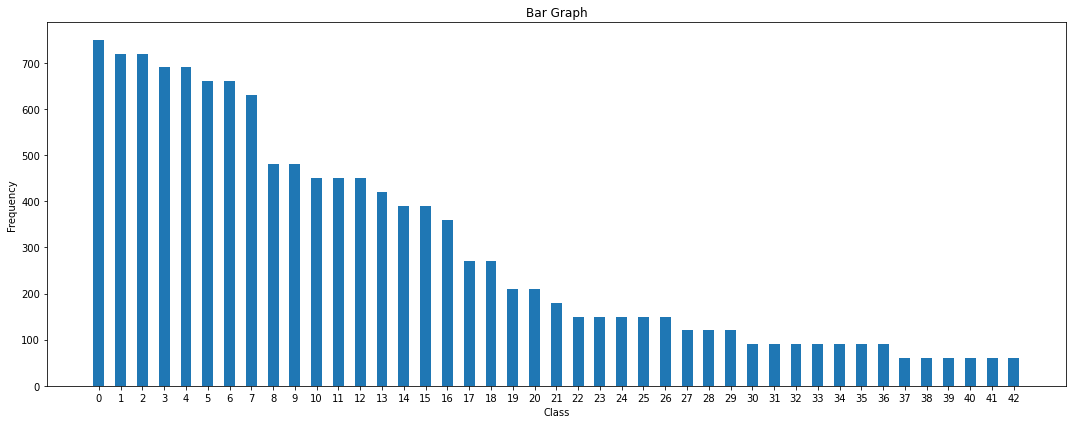

In [25]:
viewStatistics(df_test)

In [26]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


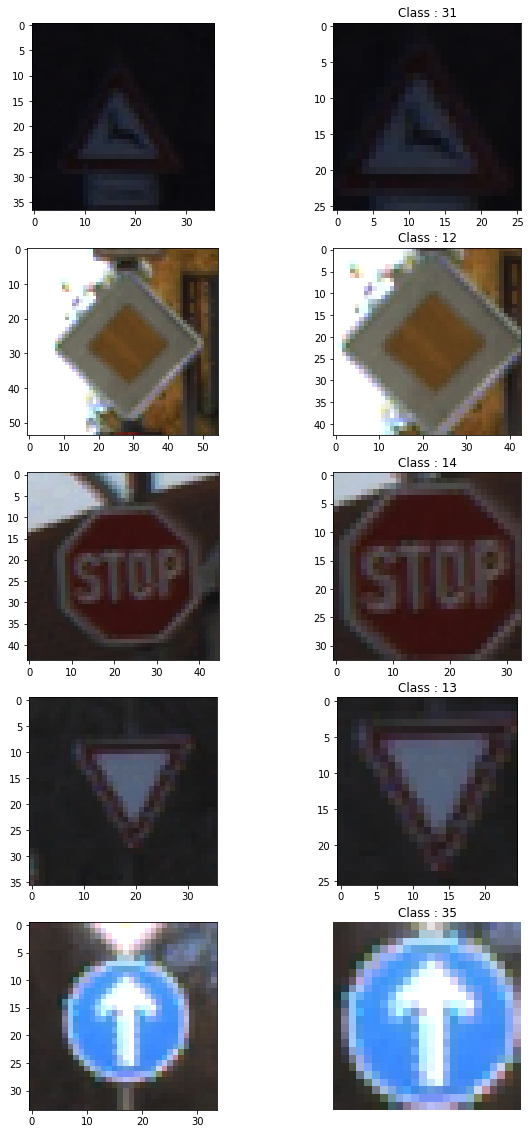

In [27]:
showTestExamples(df_test)

In [28]:
X = df_test.drop(Y_col_name, axis=1)
y = df_test[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_test = pd.DataFrame(X_resampled, columns=X.columns)
df_test[Y_col_name] = y_resampled
df_test[Y_col_name] = df_test[Y_col_name].astype(str)

In [29]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Path,ClassId
0,53,54,6,5,48,49,Test/00000.png,16
1,42,45,5,5,36,40,Test/00001.png,1
2,48,52,6,6,43,47,Test/00002.png,38
3,27,29,5,5,22,24,Test/00003.png,33
4,60,57,5,5,55,52,Test/00004.png,11


In [30]:
test_images = []
data = Data(df_test,resize_x,resize_y)
data.Get_Data()
X_test  = data.X
y_test = data.Y
X_test/=255.0

In [31]:
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

In [32]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  2.3255813953488373

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



 Summarizing the results : 


,Class,Precision,Recall,F1-Score,Support
0,30,0.02,1.0,0.05,750


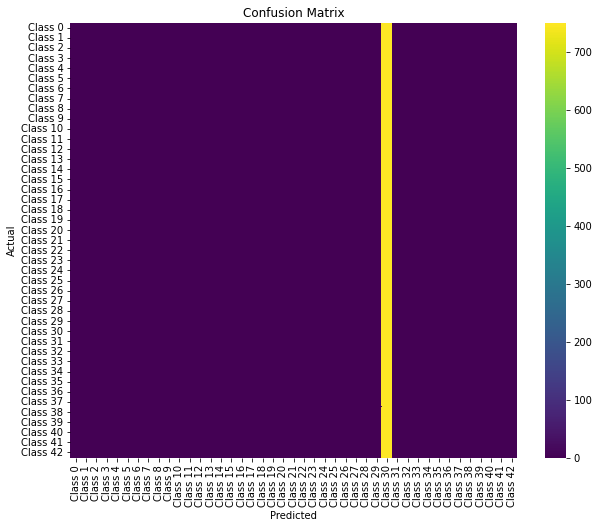

In [33]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()